DUYGU TANIMA

Bağlantılar

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

# Drive bağlantımızı yaptık

Mounted at /gdrive
/gdrive


In [2]:
import os

os.chdir('/gdrive/My Drive/Duygu_Tanima/')

# İlgili klasörün içine girdik

In [3]:
!ls

data  Duygu_Tanima.ipynb  images


Gerekli Paketlerin Yüklenmesi

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

#Gerekli kütüphaneleri import ettik

Veri Setinin Okunması

In [5]:
root = '/gdrive/My Drive/Duygu_Tanima/'

data = pd.read_csv(root + 'data/fer2013/fer2013.csv')
data.shape

# Üç sütundan ve 35887 satırdan oluşan bir veri setimiz var

(35887, 3)

Veriden Bir Parça Görelim

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Eğitim ve Test Performansının Ölçüldüğü Veri Sayılarını İnceleyelim

In [7]:
data["Usage"].value_counts()

# Usage kolonunda verisetindeki örneklerin kaç gruba ayrıldığını gördük
# Kaggleda bu şekilde submit sonrası asıl test edilmesi için verisetinden bir kısmını "PrivateTest" olarak ayırmışlar

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

Ön İşleme Adımları

In [8]:
np.unique(data["Usage"].values.ravel())

print('Eğitim setindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

# Eğitimimizi Training üzerinden yapıyoruz ve örnek sayımız 28709

Eğitim setindeki örnek sayısı: 28709


In [9]:
train_data = data [data.Usage == "Training"]

# Sadece eğitim örneklerini train_data değişkenine aldık

In [10]:
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

# Eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
# Aşağıda tüm görüntülerin piksel değerlerini görüyoruz, altta ise eğitim sayısı ve shape

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [11]:
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

# Görüntüyü 48x48 piksel şeklinde göstermek için bir fonksiyon tanımladık, reshape ettik

Eğitim Kümesinden Örnek Görsel

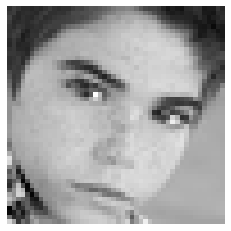

In [12]:
show(train_images[741])

# 1 - 28709 a kadar olan herhangi bir sayıyı girdik

In [13]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

# Eğitim setinde kaç farklı sınıf yani duygu var bunu bulduk

Farklı yüz ifadelerinin sayısı: 7


In [14]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# One Hot ile eğitim kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görücez

In [15]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

# Eğitim setindeki eleman sayısı ve her eleman için duygu durum sayısını görterdik

(28709, 7)


Test Verisi Ön İşleme Adımları

In [16]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

# Eğitim işlemi için veri kümesinde ayrılmış olan PublicTest kısmını aldık

Test verisetindeki örnek sayısı: 3589


In [17]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

# Test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
# Test setindeki örnek sayısı ve bunların parse edilmiş sayısı geldi

(3589, 2304)


Test Kümesinden Örnek Görsel

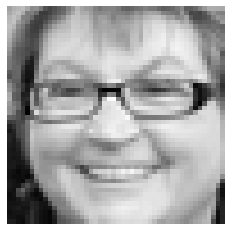

In [18]:
show(test_images[100])

# 1 - 3589 a kadar olan herhangi bir sayıyı girdik

In [19]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

# Test setindeki eleman sayısı ve her eleman için duygu durum sayısını görterdik

(3589, 7)


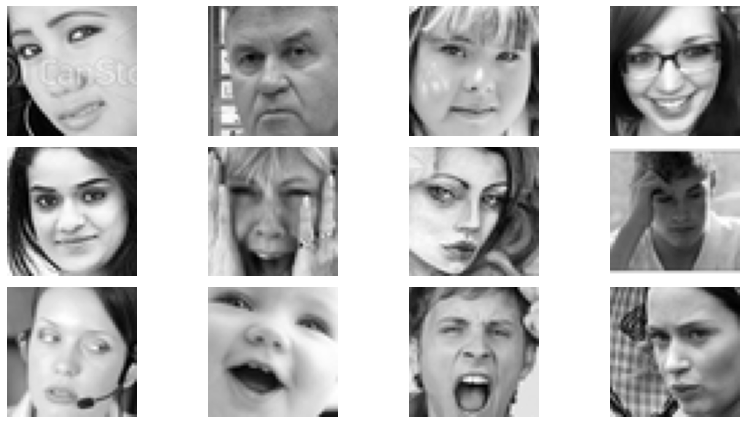

In [20]:
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# Test verisetinden örneklerden bir kaçını toplu halde görelim

Derin Evrişimli Sinir Ağı Modeli Tanımlanması

In [21]:
model = Sequential()

# 1. Katman
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 2. Katman

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) # %60 unutma işlemi(nöron silme-dropout)

### 3. Katman
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. Katman
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. Katman
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### Tam Bağlantı Katmanı
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
#model özetini görselleştirelim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0

Eğitim ve Test Kümelerinin Eleman Sayısı, Yükseklik - Genişlik, Kanal Sayısıs Bilgileri

In [22]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


Eğitim ve Test Kümelerinin Eleman ve Duygu Sınıf Sayısı

In [23]:
print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


Modelin Eğitimi

In [24]:
checkpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)
# en başarılı ağırlıkları kaydettik

epochs = 30
batchSize = 100

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

# Veri zenginleştirme uyguladık

In [25]:
hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True, #görselleri karıştırdık
                 batch_size=batchSize,
                 validation_data=(x_test, y_test), #public testi kullanacağız
                 callbacks=[checkpointer], verbose=2)
# modeli çalıştırdık
                
model_json = model.to_json()
with open(root + 'data/face_model.json', 'w') as json_file:
  json_file.write(model_json)
# modeli json formatında kaydettik

Epoch 1/30
288/288 - 529s - loss: 2.0070 - accuracy: 0.2554 - val_loss: 1.6053 - val_accuracy: 0.3859

Epoch 00001: val_loss improved from inf to 1.60528, saving model to /gdrive/My Drive/Duygu_Tanima/data/face_model.h5
Epoch 2/30
288/288 - 524s - loss: 1.6428 - accuracy: 0.3592 - val_loss: 1.4823 - val_accuracy: 0.4216

Epoch 00002: val_loss improved from 1.60528 to 1.48235, saving model to /gdrive/My Drive/Duygu_Tanima/data/face_model.h5
Epoch 3/30
288/288 - 529s - loss: 1.5145 - accuracy: 0.4101 - val_loss: 1.4330 - val_accuracy: 0.4492

Epoch 00003: val_loss improved from 1.48235 to 1.43302, saving model to /gdrive/My Drive/Duygu_Tanima/data/face_model.h5
Epoch 4/30
288/288 - 526s - loss: 1.4494 - accuracy: 0.4405 - val_loss: 1.3438 - val_accuracy: 0.4815

Epoch 00004: val_loss improved from 1.43302 to 1.34382, saving model to /gdrive/My Drive/Duygu_Tanima/data/face_model.h5
Epoch 5/30
288/288 - 534s - loss: 1.3936 - accuracy: 0.4627 - val_loss: 1.2979 - val_accuracy: 0.4904

Epoch

Sonuçları Yazdıralım

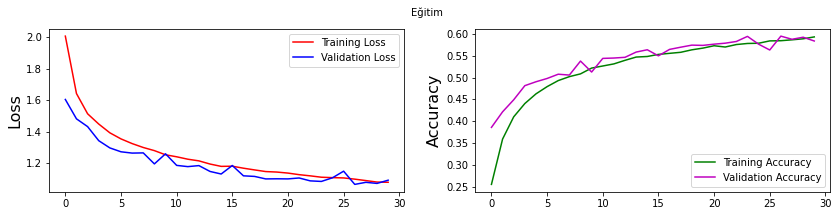

In [26]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [27]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

# Kaggle submit edecek gibi PrivateTest örnekleri ile test edelim

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [28]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [29]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

# Private Testin boyutlarına bakmış olduk

((3589, 48, 48, 1), (3589, 7))

In [30]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

# Veri kümseindeki eğitim kısmı ile modeli eğitip test için ayırılan veri ile test işlemlerini yaptık

PrivateTest üzerindeki doğruluk durumu: [1.0501554012298584, 0.6065756678581238]


Farklı Görüntülerle Test İşlemleri

In [31]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

# Gerekli kütüphanleri import ettik

In [32]:
model_best = load_model(root + 'data/face_model.h5')

# Daha önceki eğitimde kaydettiğimiz modelin hesapladığını öğrenilmiş ağırlık dosyasını kullanıyoruz

In [33]:
os.chdir('/gdrive/My Drive/Duygu_Tanima/images')

In [34]:
!ls

dogal1.jpg   igrenme1.jpg  kizgin1.jpg	korku2.jpg  mutlu3.jpg	 uzgun1.jpg
dogal2.jpg   igrenme2.jpg  kizgin2.jpg	korku3.jpg  sasgın1.jpg  uzgun2.jpg
dogal3.jpg   igrenme3.jpg  kizgin3.jpg	mutlu1.jpg  sasgın2.png  uzgun3.jpg
furkis.jpeg  kados.jpeg    korku1.jpg	mutlu2.jpg  sasgın3.jpg


In [49]:
image_path = root + "images/korku2.jpg"

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[0.14741375, 0.01903486, 0.23226134, 0.09089026, 0.22663389,
        0.12808119, 0.15568468]], dtype=float32)

Sonuçların Görselleştirilmesi

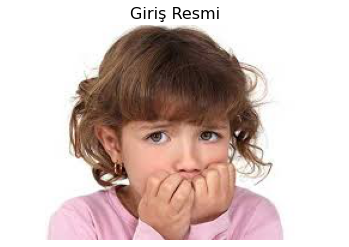

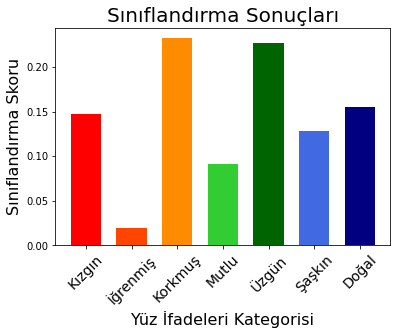

Sınıflandırma sonucu en yüksek oranla: Korkmuş


In [50]:
class_names = ['Kızgın', 'İğrenmiş', 'Korkmuş', 'Mutlu', 'Üzgün', 'Şaşkın', 'Doğal']
#s Sınıflarımız 7 adet duygu durumumuz

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()
# test resmimizi çizdirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()
#sonuçlarımızı renklendirelim

print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])